In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

In [2]:
threshold = 0.2
noise_threshold = -99999 #set this to 400
# sensor_geom = '50x25x150_1100fb'
# train_dataset_name = 'dataset_2s' # for train datasets
# test_dataset_name = 'dataset_2s' # for location of test (physical pT) datasets
# dataset_savedir = 'dataset_2s_filtering'
# dirtest = '/location/of/parquets/smartpixels/'+test_dataset_name+'/'+test_dataset_name+'_'+sensor_geom+'_parquets/unflipped/'
# dir_data = '/uscms/home/bweiss/nobackup/smart-pixels/unflipped/' #this is dataset 2s
# dir_labels = '/uscms/home/bweiss/nobackup/smart-pixels/dataset8/labels/'
dir_train = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_3s_50x12P5_parquets/unflipped/'
# dir_train = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_2s_50x12P5_parquets/unshuffled/'


# /location/of/parquets/smartpixels/dataset_2s/dataset_2s_50x12P5_parquets/unflipped
dftest = pd.read_parquet(dir_train+'labels_d16401.parquet')
print(dftest.head())
print(dftest.tail())

      x-entry    y-entry  z-entry        n_x       n_y       n_z  \
0  263.379913   6.573097    100.0 -19.512375 -0.244761 -3.990751   
1  189.428391   2.636185    100.0  -6.506950 -0.142106 -1.403364   
2 -105.093231  11.107875    100.0   6.012736  0.162117 -2.576504   
3  196.844818 -14.466997    100.0  -2.745467  0.036515 -0.732855   
4 -346.149475  -5.354011    100.0  24.983065 -0.536664 -3.990835   

   number_eh_pairs  y-local        pt  cotAlpha   cotBeta  y-midplane  \
0          62765.0 -1.71100  3.998250  4.889399  0.061332    3.506494   
1          47464.0 -2.66939  1.410540  4.636680  0.101261   -2.426864   
2          30552.0  2.08771  2.581600 -2.333680 -0.062921   14.253940   
3          41654.0  2.19853  0.733765  3.746262 -0.049826  -11.975713   
4          82560.0 -4.16523 -4.026760 -6.260110  0.134474  -12.077717   

   x-midplane  
0   18.909950  
1  -42.405616  
2   11.590772  
3    9.531707  
4  -33.143989  
          x-entry    y-entry  z-entry        n_x       n

120  files present in directory.


100%|██████████| 40/40 [00:04<00:00,  9.94it/s]
1999085it [00:55, 36179.41it/s]


iter_0:  1930771
iter_1:  34116
iter_2:  34198
iter_rem:  0


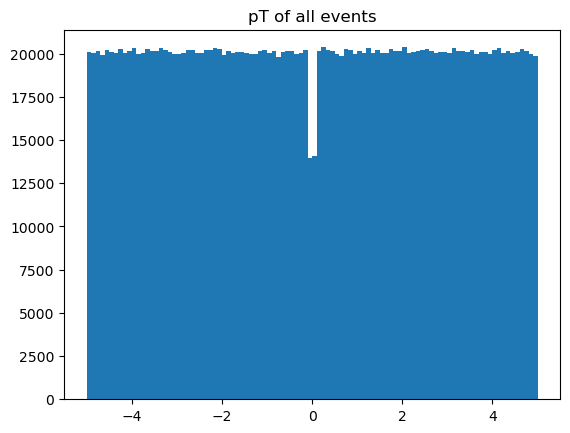

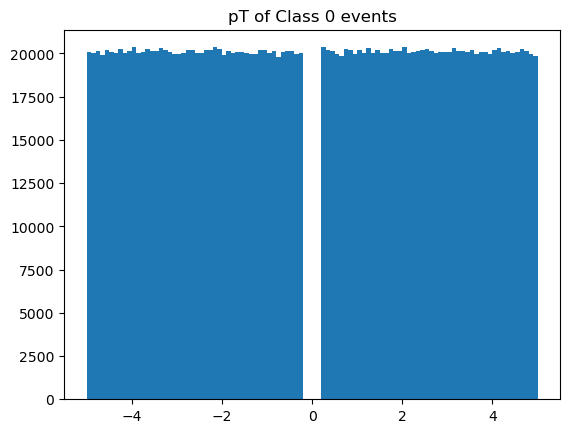

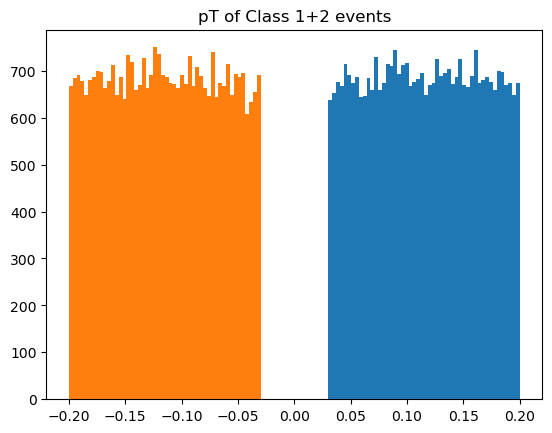

Number of events:  34000


In [3]:
testlabels = []
testrecons = []

iter=0
suffix = 16400
for filepath in glob.iglob(dir_train+'labels*.parquet'):
    iter+=3
print(iter," files present in directory.")
for i in tqdm(range(int(iter//3))):
        testlabels.append(pd.read_parquet(dir_train+'/labels_d'+str(suffix+i+1)+'.parquet'))
        testrecons.append(pd.read_parquet(dir_train+'/recon2D_d'+str(suffix+i+1)+'.parquet'))
testlabels_csv = pd.concat(testlabels, ignore_index=True)
testrecons_csv = pd.concat(testrecons, ignore_index=True)

iter_0, iter_1, iter_2 = 0, 0, 0
iter_rem = 0
for iter, row in tqdm(testlabels_csv.iterrows()):
    if(abs(row['pt'])>threshold):
        iter_0+=1
    elif(-1*threshold<=row['pt']<0):
        iter_1+=1
    elif(0<row['pt']<=threshold):
        iter_2+=1
    else:
        iter_rem+=1
print("iter_0: ",iter_0)
print("iter_1: ",iter_1)
print("iter_2: ",iter_2)
print("iter_rem: ",iter_rem)

plt.hist(testlabels_csv['pt'], bins=100)
plt.title('pT of all events')
plt.show()

plt.hist(testlabels_csv[abs(testlabels_csv['pt'])>threshold]['pt'], bins=100)
plt.title('pT of Class 0 events')
plt.show()

plt.hist(testlabels_csv[(0<=testlabels_csv['pt'])&(testlabels_csv['pt']<=threshold)]['pt'], bins=50)
plt.hist(testlabels_csv[(-1*threshold<=testlabels_csv['pt'])& (testlabels_csv['pt']<0)]['pt'], bins=50)
plt.title('pT of Class 1+2 events')
plt.show()

number_of_events = (min(iter_1, iter_2)//1000)*1000
if(number_of_events*2>iter_0):
    number_of_events = (iter_0//1000)*1000/2
number_of_events = int(number_of_events)
print("Number of events: ",number_of_events)


In [8]:
np.set_printoptions(threshold=sys.maxsize)
def sumRow(X):
    X = np.where(X < noise_threshold, 0, X)
    sum1 = 0
    sumList = []
    for i in X:
        sum1 = np.sum(i,axis=0)
        sumList.append(sum1)
        b = np.array(sumList)
    return b
testlist1, testlist2 = [], []

for (index1, row1), (index2, row2) in tqdm(zip(testrecons_csv.iterrows(), testlabels_csv.iterrows())):
    rowSum = 0.0
    X = row1.values
    X = np.reshape(X,(13,21))
    rowSum = sumRow(X)
    testlist1.append(rowSum)
    cls = -1
    if(abs(row2['pt'])>threshold):
        cls=0
    elif(-1*threshold<=row2['pt']<0):
        cls=1
    elif(0<=row2['pt']<=threshold):
        cls=2
    testlist2.append([row2['y-local'], cls, row2['pt']])
testdf_all = pd.concat([pd.DataFrame(testlist1), pd.DataFrame(testlist2 , columns=['y-local', 'cls', 'pt'])], axis=1)
print(testdf_all.head())

1999085it [05:08, 6475.43it/s]


     0    1       2        3        4        5        6       7    8    9  \
0  0.0  0.0     0.0   2287.0  16384.0  15663.0  25023.0  3408.0  0.0  0.0   
1  0.0  0.0    24.0   8763.0  22956.0  10041.0   5680.0     0.0  0.0  0.0   
2  0.0  0.0     0.0      0.0    110.0  13994.0  11799.0  4649.0  0.0  0.0   
3  0.0  0.0   279.0  22753.0  13832.0   4790.0      0.0     0.0  0.0  0.0   
4  0.0  4.0  6137.0  26827.0  36845.0  11947.0    800.0     0.0  0.0  0.0   

    10   11   12  y-local  cls        pt  
0  0.0  0.0  0.0 -1.71100    0  3.998250  
1  0.0  0.0  0.0 -2.66939    0  1.410540  
2  0.0  0.0  0.0  2.08771    0  2.581600  
3  0.0  0.0  0.0  2.19853    0  0.733765  
4  0.0  0.0  0.0 -4.16523    0 -4.026760  


In [9]:
main_dir = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_3s_50x12P5_parquets/'
dataset_savedir = os.path.join(main_dir, 'train_test_3s')
totalsize = number_of_events#227000
dset = 'Train'

random_seed0 = 10#11
random_seed1 = 13#14
random_seed2 = 19#20

testdf_all = testdf_all.sample(frac=1, random_state=random_seed0).reset_index(drop=True)
# testdf_all.to_csv(dataset_savedir+'/'+'/FullTestData_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
testdf_all.to_csv(dataset_savedir+f'/Full{dset}Data.csv', index=False)
testdfcls0 = testdf_all.loc[testdf_all['cls']==0]
testdfcls1 = testdf_all.loc[testdf_all['cls']==1]
testdfcls2 = testdf_all.loc[testdf_all['cls']==2]
# print(testdfcls0.shape)
# print(testdfcls1.shape)
# print(testdfcls2.shape)
# print(testdfcls2.head())
testdfcls0 = testdfcls0.iloc[:2*totalsize]
testdfcls1 = testdfcls1.iloc[:totalsize]
testdfcls2 = testdfcls2.iloc[:totalsize]
# print(testdfcls2.head())

testcls0 = testdfcls0.sample(frac = 1, random_state=random_seed1)
testcls1 = testdfcls1.sample(frac = 1, random_state=random_seed1)
testcls2 = testdfcls2.sample(frac = 1, random_state=random_seed1)
test = pd.concat([testcls0, testcls1, testcls2], axis=0)

test = test.sample(frac=1, random_state=random_seed2)
# test=testdf_all
# print(testcls0.shape)
# print(testcls1.shape)
# print(testcls2.shape)
print(test.shape)

testlabel = test['cls']
testpt = test['pt']
test = test.drop(['cls', 'pt'], axis=1)

print(test.shape)
print(testlabel.shape)
print(testpt.shape)

test.to_csv(dataset_savedir + f'/FullPrecisionInput{dset}Set.csv', index=False)
testlabel.to_csv(dataset_savedir + f'/{dset}SetLabel.csv', index=False)
testpt.to_csv(dataset_savedir + f'/{dset}SetPt.csv', index=False)

(136000, 16)
(136000, 14)
(136000,)
(136000,)


In [ ]:
# plotdata = pd.concat([traincls0['pt'], testcls0['pt']], axis=0)
# #print(plt.hist(traincls0['pt'], bins=100))
# #print(plt.hist(testcls0['pt'], bins=100))
# plt.hist(traincls0['pt'], bins=100)
# plt.hist(testpt, bins=100)
# plt.xticks(np.arange(-5, 5, 1))
# plt.show()

In [ ]:
# Dataset 2s
# 0.1 threshold =  288000 total events for test/train!?
# 0.125 thresh  = 432000 total events for test/train
# 0.15 thresh   = 588000 total events for test/train!?
# 0.175 thresh  = 748000 total events for test/train
# 0.2 threshold =  908000 total events for test/train
# 0.3 threshold = 1536000 total events for test/train!?
# 0.4 threshold = 1998000 total events for test/train
# 0.5 threshold = 1566000 total events for test/train
# 100x25x100, dataset4s_50x12.5 follows above numbers. Not sure what about 50x25 which used the new random_seeds I believe.
# For 100x25x150 and maybe for the new random seeds): 0,1=284000, 0.15=576000, 0.2=896000, 0.3=1516000, 0.4=1898000, 0.5=1550000
# For dataset 6s_50x12P5, 0.1=288000, 0.15=584000, 0.2=888000, 0.3=1532000, 0.4=2000000, 0.5=1568000
# For dataset_6s_50x10, 0.1=284000, 0.15=584000, 0.4=2000000, 0.5=1568000
# For dataset 6s_50x15,20,25, 100x25x150 0.1=288000, 0.15=584000, 0.3=1532000, 0.4=2000000, 0.5=1568000
# For dataset 9s phase2_370fb,1100fb: 0.1=284, 0.15=576, 0.2=896, 0.3=1516, 0.4=1978, 0.5=1550
# Dataset 1s
# 0.1 threshold =  288000 total events for test/train
# 0.15 threshold = 588000 total events for test/train
# 0.2 threshold =  908000 total events for test/train
# 0.3 threshold = 1536000 total events for test/train
# 0.4 threshold = 1916000 total events for test/train
# 0.5 threshold = 1484000 total events for test/train

# Dataset 3s
# 0.1 threshold =  52000 total events for train
# 0.15 threshold = 96000 total events for train
# 0.2 threshold =  136000 total events for train
# 0.3 threshold =  216000 total events for train
# 0.4 threshold =  296000 total events for train
# 0.5 threshold =  376000 total events for train
# for 100x25x150, the stats were lesser by 4k events all pt boundaries except 0.1
# For dataset_7s_50x12.5,10,15 the stats were lesser by 4k events all pt boundaries except 0.1,0.3,0.5
# For dataset 9s phase2_370fb,1100fb: the stats were lesser by 4k events all pt boundaries except 0.1